In [45]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l2
import tensorflow as tf
from tensorflow.keras import layers
import torch
import numpy as np
from tqdm.notebook import tqdm
from gensim.models import Word2Vec
import random 
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import keras_tuner as kt
from tqdm import tqdm

## **Data Pipeline**

We first import the preprocessed lexed arrays and labels created from preprocessing.ipynb.

In [4]:
def getLexedArrays(path, size=-1):
    '''
        Retrieves the lexed tokens from the preprocessed datasets
    '''
    array = []
    with open(path, 'r') as f:
        i = 0
        while size == -1 or i < size:
            line = f.readline()
            if line:
                array.append(line.split())
                i += 1
            else:
                break
    return array


def getLabels(path, size=-1):
    '''
        Retrieves the labels corresponding to each lexed array
    '''
    array = []
    with open(path, 'r') as f:
        i = 0
        while size == -1 or i < size:
            line = f.readline()
            if line:
                array.append(int(line))
                i += 1
            else:
                break
    return array

In [5]:
test_arrays = getLexedArrays('../input/vdisc-datasets/archive (1)/lexed_VDISC/VDISC_test')
train_arrays = getLexedArrays('../input/vdisc-datasets/archive (1)/lexed_VDISC/VDISC_train')
val_arrays = getLexedArrays('../input/vdisc-datasets/archive (1)/lexed_VDISC/VDISC_validate')

test_labels = getLabels('../input/vdisc-datasets/archive (2)/labels_VDISC/VDISC_test')
train_labels = getLabels('../input/vdisc-datasets/archive (2)/labels_VDISC/VDISC_train')
val_labels = getLabels('../input/vdisc-datasets/archive (2)/labels_VDISC/VDISC_validate')

We exclude classes 4 and 5 (corresponding to CWE-476 and CWE-other respectively).

In [6]:
def exclusion(array, label):
    i = 0
    while i < len(array):
        if label[i] in (4, 5):
            array.pop(i)
            label.pop(i)
        else:
            i += 1

exclusion(test_arrays, test_labels)
exclusion(train_arrays, train_labels)
exclusion(val_arrays, val_labels)

In [7]:
test_labels = np.array(test_labels)
train_labels = np.array(train_labels)
val_labels = np.array(val_labels)

The following code splits the classes and labels of each of test, train, and val datasets into the following schema.

In [8]:
# SCHEMA
# 4xk 2D Array
# [
#     [ class_0 ],           - label_0
#     [ class_1 ],           - label_1
#     [ class_2 ],           - label_2
#     [ class_3 ],           - label_3
# ]

ds_sizes = [9000, 90000, 9000]
test_classes, train_classes, val_classes = [[[(test_arrays, train_arrays, val_arrays)[k][j] for j in np.resize(np.array(np.nonzero(labels == i)[0]), ds_sizes[k])] for i in (-1, 1, 2, 3)] for k, labels in enumerate((test_labels, train_labels, val_labels))]

# Testing code
# print(len(test_classes))
# print(len(test_classes[0]))

We need to determine the maximum length of the lexed arrays so we can zero-pad the shorter arrays later on.

In [9]:
max_len = 0
for lexed_arrays in (test_arrays, train_arrays, val_arrays):
    for ar in lexed_arrays:
        max_len = max(max_len, len(ar))

#### **Create Tensorflow Datasets from Generator**

We must make our data palatable to tensorflow's input pipeline by first creating a generator function. We use this approach as opposed to loading our whole dataset as a tensor dataset to save on memory usage.

In [10]:
# Vector dimension is determined by the embedding model in embedding.ipynb.
VEC_DIM = 15

def data_generator(dataset, isLabelled=True):
    '''
        Data generator function that yields one embedded array per take.
        The different classes are yielded in turn in a loop, so class 0 
        will be yielded first followed by class 1 -> class 2 -> class 3 -> class 0
    '''
    
    w2vmodel = Word2Vec.load("../input/vdisc-datasets/archive/embedding.model")
    vec_ems = np.zeros((max_len, VEC_DIM))
    for i in range(len(dataset[0])):
        for j in range(len(dataset)):
            ar = dataset[j][i]
            
            # Zero vector embeddings array
            vec_ems *= 0
            
            # For each lexed token, we retrieve the vector embedding and populate our array with it
            for o, k in enumerate(ar):
                vec = None
                if k not in w2vmodel.wv:
                    vec = w2vmodel.wv['<|na|>']
                else:
                    vec = w2vmodel.wv[k]
                vec_ems[o, :] = vec
                
            if isLabelled:
                yield (vec_ems, j)
            else:
                yield vec_ems
    

test_ds = tf.data.Dataset.from_generator(
    lambda: data_generator(test_classes),
    output_types=(tf.float32, tf.float32), 
    output_shapes=((max_len, VEC_DIM), ()),
)

train_ds = tf.data.Dataset.from_generator(
    lambda: data_generator(train_classes),
    output_types=(tf.float32, tf.float32), 
    output_shapes=((max_len, VEC_DIM), ()),
)

val_ds = tf.data.Dataset.from_generator(
    lambda: data_generator(val_classes, False),
    output_types=(tf.float32), 
    output_shapes=(max_len, VEC_DIM),
)

AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32

train_ds = train_ds.repeat().batch(batch_size).prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.repeat().batch(batch_size).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.batch(batch_size).prefetch(buffer_size=AUTOTUNE)

## **Model Training**

We begin by constructing the model architecture. Note that we must define the CNN model and dense layers separately because we want to use the CNN model only for the random forest later.

In [10]:
# Overall model structure:
# [
#     Input,
#     Conv_2d,
#     max_pooling,
#     Flatten,
#     Dropout + Dense (n times),
#     Dense output layer
# ]

def model_builder(hp):
    '''
        Model builder function to be passed into keras tuner
    '''
    
    NUM_FILTERS = 32

    hp_learning_rate = hp.Choice('learning_rate', values=[1e-3, 3e-4, 1e-4])
    hp_l2_factor = hp.Choice('l2_factor', values=[1e-2, 1e-1, 1.0, 10.0])
    hp_num_dense_layers = hp.Choice('num_dense_layers', values=[3, 4, 5])
    hp_dense_units = hp.Int('units', min_value=128, max_value=256, step=64)

    input_layer = layers.Input(shape=(max_len, VEC_DIM, 1))

    cnn_model = Sequential([
        layers.Conv2D(filters=NUM_FILTERS, kernel_size=(15, 15), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2=hp_l2_factor)),
        layers.GlobalMaxPooling2D(),
        layers.Flatten(),
    ])
    
    model_layers = []
    
    for i in range(hp_num_dense_layers):
        model_layers.append(layers.Dropout(0.5))
        model_layers.append(layers.Dense(hp_dense_units, activation='relu'))
    
    model_layers.append(layers.Dense(6))

    dense_model = Sequential(model_layers)
    
    # "Concatenate" the CNN model and Dense layers together
    cnn_output = cnn_model(input_layer)
    final_output = dense_model(cnn_output)

    model = tf.keras.Model(inputs=input_layer, outputs=final_output)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])
    
    return model

In [ ]:
# We must use .take because train_ds and test_ds do not have a fixed size
train_ds_0 = train_ds.take(ds_sizes[1]//batch_size)
test_ds_0 = test_ds.take(ds_sizes[0]//batch_size)

tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     directory='.')

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)
tuner.search(train_ds_0, epochs=10, validation_data=test_ds_0, callbacks=[stop_early])

best_model = tuner.get_best_models()[0]

In [15]:
tuner.get_best_hyperparameters()[0].values

{'learning_rate': 0.0001,
 'l2_factor': 0.1,
 'num_dense_layers': 3,
 'units': 128,
 'tuner/epochs': 10,
 'tuner/initial_epoch': 4,
 'tuner/bracket': 2,
 'tuner/round': 2,
 'tuner/trial_id': '0012'}

In [ ]:
# Fit the model for 15 more epochs
model = best_model 

epochs=15
history = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=epochs,
    steps_per_epoch = ds_sizes[1]//batch_size,
    validation_steps = ds_sizes[0]//batch_size,
    callbacks=[keras.callbacks.EarlyStopping(monitor='loss', patience=3)]
)

Epoch 1/15
2812/2812 ━━━━━━━━━━━━━━━━━━━━ 132s 45ms/step - accuracy: 0.6767 - loss: 0.8633 - val_accuracy: 0.7026 - val_loss: 0.8083
Epoch 2/15
2812/2812 ━━━━━━━━━━━━━━━━━━━━ 125s 44ms/step - accuracy: 0.6781 - loss: 0.8584 - val_accuracy: 0.7101 - val_loss: 0.8026
Epoch 3/15
2812/2812 ━━━━━━━━━━━━━━━━━━━━ 126s 45ms/step - accuracy: 0.6812 - loss: 0.8578 - val_accuracy: 0.7102 - val_loss: 0.7935
Epoch 4/15
2812/2812 ━━━━━━━━━━━━━━━━━━━━ 128s 45ms/step - accuracy: 0.6831 - loss: 0.8520 - val_accuracy: 0.7048 - val_loss: 0.8072
Epoch 5/15
2812/2812 ━━━━━━━━━━━━━━━━━━━━ 128s 46ms/step - accuracy: 0.6903 - loss: 0.8477 - val_accuracy: 0.7174 - val_loss: 0.8039
Epoch 6/15
2812/2812 ━━━━━━━━━━━━━━━━━━━━ 132s 47ms/step - accuracy: 0.6872 - loss: 0.8451 - val_accuracy: 0.7046 - val_loss: 0.8074
Epoch 7/15
2812/2812 ━━━━━━━━━━━━━━━━━━━━ 141s 50ms/step - accuracy: 0.6884 - loss: 0.8460 - val_accuracy: 0.7040 - val_loss: 0.8306
Epoch 8/15
2735/2812 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.

#### **Evaluation of Model**

We will construct a confusion matrix to evaluate the model.

In [98]:
predictions = model.predict(val_ds)

1125/1125 ━━━━━━━━━━━━━━━━━━━━ 40s 35ms/step


/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


In [99]:
a = np.zeros((4, 4))

for i, p in enumerate(tqdm(predictions)):
    score = tf.nn.softmax(p)
    a[i % 4,int(np.argmax(score))] += 1


100%|██████████| 36000/36000 [00:13<00:00, 2625.71it/s]


Text(0.5, 1.0, 'Confusion Matrix for Dense Model')

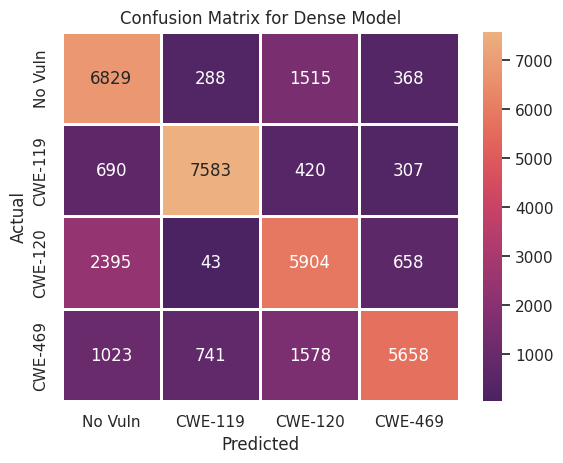

In [100]:
sns.set_theme()
sns.heatmap(a, 
            linewidths=1, 
            annot=True, 
            fmt='g',
            xticklabels=['No Vuln', 'CWE-119', 'CWE-120', 'CWE-469'], 
            yticklabels=['No Vuln', 'CWE-119', 'CWE-120', 'CWE-469'],
            cmap='flare_r'
)

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Dense Model')

## **Ensemble**

Now, we train the random forest model. We first prepare an unlabelled dataset from the train dataset. The labels are generated separately.

In [12]:
train_ds2 = tf.data.Dataset.from_generator(
    lambda: data_generator(train_classes, False),
    output_types=(tf.float32), 
    output_shapes=(max_len, VEC_DIM),
)

train_ds2 = train_ds2.batch(batch_size).prefetch(buffer_size=AUTOTUNE)
classes = [i % 4 for i in range(len(train_classes[0]) * len(train_classes))]

In [16]:
cnn_model = model.layers[1]
cnn_model.summary()
train_representations = cnn_model.predict(train_ds2)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 1008, 1, 32)    │         7,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling2d            │ (None, 32)             │             0 │
│ (GlobalMaxPooling2D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,232 (28.25 KB)

 Trainable params: 7,232 (28.25 KB)

 Non-trainable params: 0 (0.00 B)

11250/11250 ━━━━━━━━━━━━━━━━━━━━ 396s 35ms/step


/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


We train the random forest on the CNN-generated representations.

In [37]:
from sklearn.model_selection import RandomizedSearchCV

# Hyperparameter tuning
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 500, num = 50)]
max_depth = [int(x) for x in np.linspace(30, 80, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]
random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

rf = RandomForestClassifier()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 150, cv = 3)
rf_random.fit(train_representations[:50 * batch_size], classes[:50 * batch_size])

RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=150,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [30, 35, 40, 45, 50, 55,
                                                      60, 65, 70, 75, 80,
                                                      None],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 206, 212, 218,
                                                         224, 230, 236, 242,
                                                         248, 255, 261, 267,
                                                         273, 279, 285, 291,
                                                         297, 304, 310, 316,
                                                         322, 328, 334, 340,
                                                         346, 353, 359, 365,
                                                         371, 377, ...]})

In [38]:
rf_model = rf_random.best_estimator_

#### **Model Evaluation**

In [74]:
val_representations = cnn_model.predict(val_ds)
predictions = rf_model.predict(val_representations)

1125/1125 ━━━━━━━━━━━━━━━━━━━━ 40s 35ms/step


/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


In [79]:
from tqdm import tqdm

b = np.zeros((4, 4))

for i, p in enumerate(tqdm(predictions)):
    b[i % 4,p] += 1

100%|██████████| 36000/36000 [00:00<00:00, 567200.24it/s]


Text(0.5, 1.0, 'Confusion Matrix for Random Forest')

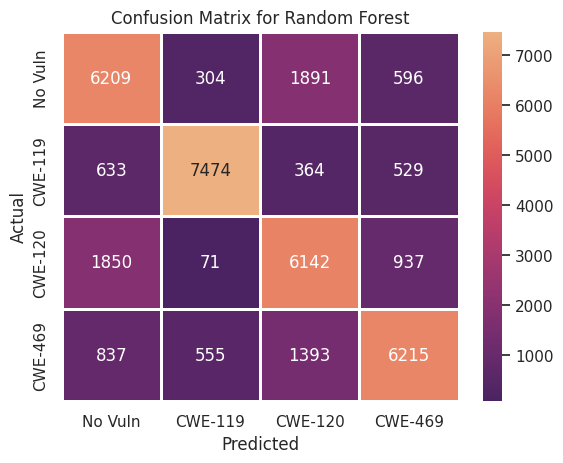

In [80]:
sns.set_theme()
sns.heatmap(b, 
            linewidths=1, 
            annot=True, 
            fmt='g',
            xticklabels=['No Vuln', 'CWE-119', 'CWE-120', 'CWE-469'], 
            yticklabels=['No Vuln', 'CWE-119', 'CWE-120', 'CWE-469'],
            cmap='flare_r'
)

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Random Forest')

In [101]:
a_v = np.zeros([2, 2])
b_v = np.zeros([2, 2])
a_v[0, 0] = a[0, 0]
a_v[1, 0] = np.sum(a[1:, 0])
a_v[0, 1] = np.sum(a[0, 1:])
a_v[1, 1] = np.sum(a[1:, 1:])

b_v[0, 0] = b[0, 0]
b_v[1, 0] = np.sum(b[1:, 0])
b_v[0, 1] = np.sum(b[0, 1:])
b_v[1, 1] = np.sum(b[1:, 1:])

Text(0.5, 1.0, 'Confusion Matrix for Dense')

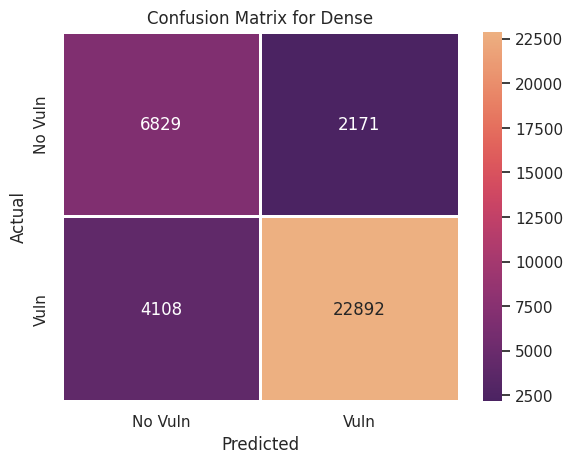

In [102]:
sns.set_theme()
sns.heatmap(a_v, 
            linewidths=1, 
            annot=True, 
            fmt='g',
            xticklabels=['No Vuln', 'Vuln'], 
            yticklabels=['No Vuln', 'Vuln'],
            cmap='flare_r'
)

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Dense')

Text(0.5, 1.0, 'Confusion Matrix for Random Forest')

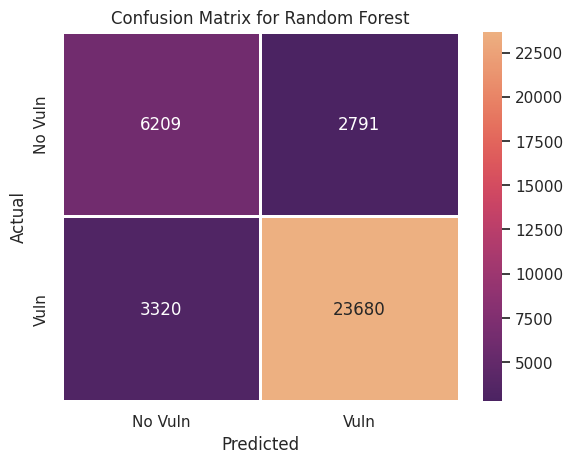

In [105]:
sns.set_theme()
sns.heatmap(b_v, 
            linewidths=1, 
            annot=True, 
            fmt='g',
            xticklabels=['No Vuln', 'Vuln'], 
            yticklabels=['No Vuln', 'Vuln'],
            cmap='flare_r'
)

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Random Forest')

Next, we calculate the false negative rate for the No Vuln class for both the Dense and Random Forest approaches.

Text(0.5, 1.0, 'Recall')

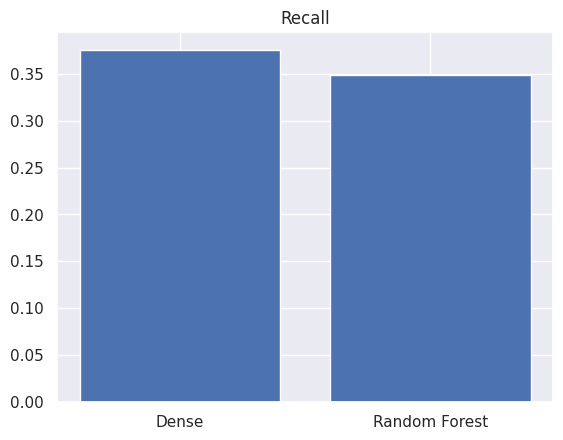

In [107]:
fnr_dense = (np.sum(a[:, 0]) - a[0, 0]) / np.sum(a[:, 0])
fnr_random_forest = (np.sum(b[:, 0]) - b[0, 0]) / np.sum(b[:, 0])

plt.bar(x=['Dense', 'Random Forest'], height=[fnr_dense, fnr_random_forest])
plt.title('Recall')

In [69]:
import joblib
joblib.dump(rf_model, "rf_model.pkl") 


['rf_model.pkl']

### **MISC**

In [ ]:
model.save('dir/model.keras')

In [70]:
model = tf.keras.models.load_model('model.keras')

In [1]:
with open('../input/kerasmodel/keras/v3/1/model (4).keras', 'rb') as f:
    with open('model.keras', 'wb') as f2:
        a = f.read()
        f2.write(a)

In [4]:
model.layers[1].summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 1008, 1, 32)    │         7,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling2d            │ (None, 32)             │             0 │
│ (GlobalMaxPooling2D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,232 (28.25 KB)

 Trainable params: 7,232 (28.25 KB)

 Non-trainable params: 0 (0.00 B)

In [5]:
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 1022, 15, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 32)             │         7,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 6)              │        38,022 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 135,764 (530.33 KB)

 Trainable params: 45,254 (176.77 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 90,510 (353.56 KB)

In [ ]:
!zip -r untilted_project.zip dir/untitled_project/

In [ ]:
!cp -fr ../input/kerastuner/dir/untitled_project .